# **Pirate Pain Challenge - Hyperparameters Tuning**

## 🌐 **Google Drive Connection or local mount**

In [149]:
import os

isColab = False
isKaggle = False

# Directory di default
current_dir = os.getcwd()

try:
    if not isColab:
        raise ImportError("We are not in google colab")
    from google.colab import drive

    drive.mount("/gdrive")
    current_dir = "/gdrive/My\\ Drive/[2025-2026]\\ AN2DL/AN2DL-challenge-1/"
    print("In esecuzione su Colab. Google Drive montato.")
    %cd $current_dir
    isColab = True

except ImportError:
    # Rilevamento ambiente Kaggle
    if os.environ.get("KAGGLE_KERNEL_RUN_TYPE") or os.path.exists("/kaggle/working") or isKaggle:
        isKaggle = True
        kaggle_work_dir = "/kaggle/working/AN2DL-challenge-1"
        os.makedirs(kaggle_work_dir, exist_ok=True)
        current_dir = kaggle_work_dir
        print("In esecuzione su Kaggle. Directory di lavoro impostata.")
    else:
        isColab = False
        isKaggle = False
        print("Esecuzione locale. Salto mount Google Drive.")
        local_pref = r"G:\Il mio Drive\Colab Notebooks\[2025-2026] AN2DL\AN2DL-challenge-1"
        current_dir = local_pref if os.path.isdir(local_pref) else os.getcwd()
        print(f"Directory corrente impostata a: {current_dir}")

# Cambio directory se non Colab (su Colab è già fatto con %cd)
if not isColab:
    os.chdir(current_dir)

print(f"Changed directory to: {current_dir}")

Esecuzione locale. Salto mount Google Drive.
Directory corrente impostata a: G:\Il mio Drive\Colab Notebooks\[2025-2026] AN2DL\AN2DL-challenge-1
Changed directory to: G:\Il mio Drive\Colab Notebooks\[2025-2026] AN2DL\AN2DL-challenge-1


## ⚙️ **Libraries Import**

In [150]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch

torch.manual_seed(SEED)
# from torchsummary import summary

logs_dir = "tensorboard"
if isColab:
    !pkill -f tensorboard
else:
    # Arresta eventuali processi tensorboard in locale (Windows)
    import os

    if os.name == 'nt':
        try:
            import psutil

            for proc in psutil.process_iter(['name', 'cmdline']):
                name = (proc.info.get('name') or '').lower()
                cmd = ' '.join(proc.info.get('cmdline') or []).lower()
                if 'tensorboard' in name or 'tensorboard' in cmd:
                    try:
                        proc.kill()
                    except Exception:
                        pass
        except ImportError:
            import subprocess

            subprocess.run(['taskkill', '/F', '/IM', 'tensorboard.exe'],
                           stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

%load_ext tensorboard
if isColab:
    !mkdir -p models
else:
    os.makedirs("../models", exist_ok=True)

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot display settings
sns.set_theme(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
PyTorch version: 2.8.0+cpu
Device: cpu


## ⏳ **Data Downloading**

In [151]:
import os
import zipfile

# --- 1. Impostazioni ---
competition_name = 'an2dl2526c1'
dataset_path = 'dataset'
if isKaggle:
    dataset_path = '/kaggle/input/pirate-pain/dataset'
train_file = 'pirate_pain_train.csv'
test_file = 'pirate_pain_test.csv'
labels_file = 'pirate_pain_train_labels.csv'
sample_submission_file = 'sample_submission.csv'

# Controlla se il dataset è già stato scaricato ed estratto
if not isKaggle and not isColab and not os.path.exists(os.path.join(dataset_path, train_file)):
    # --- 2. Autenticazione e Download ---
    from kaggle.api.kaggle_api_extended import KaggleApi

    # Inizializza l'API di Kaggle
    # L'autenticazione avviene automaticamente se 'kaggle.json' è in C:\\Users\\Bert0ns\\.kaggle\\
    api = KaggleApi()
    api.authenticate()

    print(f"Download del dataset dalla competizione '{competition_name}'...")

    # Crea la directory di destinazione se non esiste
    os.makedirs(dataset_path, exist_ok=True)

    # Scarica i file della competizione nella cartella 'dataset'
    api.competition_download_files(competition_name, path=dataset_path)

    # Estrai i file dall'archivio zip
    zip_path = os.path.join(dataset_path, f'{competition_name}.zip')
    if os.path.exists(zip_path):
        print(f"Estrazione dei file da '{zip_path}'...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(dataset_path)
        # Rimuovi il file zip dopo l'estrazione
        os.remove(zip_path)
        print("Estrazione completata e file zip rimosso.")
    else:
        print("ATTENZIONE: File zip non trovato. Il download potrebbe non essere riuscito.")
else:
    print(f"Il dataset è già presente nella cartella {dataset_path}. Download saltato.")


Il dataset è già presente nella cartella dataset. Download saltato.


## 🔎 **Exploration and Data Analysis**

In [152]:
import pandas as pd

# Load the datasets
if not isColab:
    dataset_df = pd.read_csv(os.path.join(dataset_path, train_file))
    kaggle_test_df = pd.read_csv(os.path.join(dataset_path, test_file))
    labels_df = pd.read_csv(os.path.join(dataset_path, labels_file))
else:
    dataset_df = pd.read_csv(dataset_path + '/pirate_pain_train.csv')
    kaggle_test_df = pd.read_csv(dataset_path + '/pirate_pain_test.csv')
    labels_df = pd.read_csv(dataset_path + '/pirate_pain_train_labels.csv')

**Convert data to a memory efficient form**

In [153]:

text_map = {
    'two': 0,
    'one+peg_leg': 1, 'one+hook_hand': 2, 'one+eye_patch': 3,
}

# Pulisce, normalizza, mappa; fallback a numerico e a cifre estratte
columns_to_convert = ['n_legs', 'n_hands', 'n_eyes']
for col in columns_to_convert:
    dataset_df[col] = dataset_df[col].str.strip().str.lower().map(text_map).astype('int8')
    kaggle_test_df[col] = kaggle_test_df[col].str.strip().str.lower().map(text_map).astype('int8')

# train_df.head(105760)

In [154]:
# Convert data types from float64 to float32 to save memory
dataset_df[dataset_df.select_dtypes(include=['float64']).columns] = dataset_df.select_dtypes(
    include=['float64']).astype(
    'float32')
kaggle_test_df[kaggle_test_df.select_dtypes(include=['float64']).columns] = kaggle_test_df.select_dtypes(
    include=['float64']).astype(
    'float32')

# Convert int64 to int32
dataset_df[dataset_df.select_dtypes(include=['int64']).columns] = dataset_df.select_dtypes(include=['int64']).astype(
    'int32')
kaggle_test_df[kaggle_test_df.select_dtypes(include=['int64']).columns] = kaggle_test_df.select_dtypes(
    include=['int64']).astype('int32')
labels_df[labels_df.select_dtypes(include=['int64']).columns] = labels_df.select_dtypes(include=['int64']).astype(
    'int32')

# Convert pain surveys to int8
dataset_df['pain_survey_1'] = dataset_df['pain_survey_1'].astype('int8')
dataset_df['pain_survey_2'] = dataset_df['pain_survey_2'].astype('int8')
dataset_df['pain_survey_3'] = dataset_df['pain_survey_3'].astype('int8')
dataset_df['pain_survey_4'] = dataset_df['pain_survey_4'].astype('int8')

kaggle_test_df['pain_survey_1'] = kaggle_test_df['pain_survey_1'].astype('int8')
kaggle_test_df['pain_survey_2'] = kaggle_test_df['pain_survey_2'].astype('int8')
kaggle_test_df['pain_survey_3'] = kaggle_test_df['pain_survey_3'].astype('int8')
kaggle_test_df['pain_survey_4'] = kaggle_test_df['pain_survey_4'].astype('int8')

# Convert labels sample_index to int8
label_map = {'low_pain': 1, 'no_pain': 0, 'high_pain': 2}

labels_df['label'] = labels_df['label'].str.strip().str.lower().map(label_map).astype('int8')

### **Prepare the Time feature**

In [155]:
# --- Time features: normalized_time + sin/cos ---
TIME_FEATURES = ['time_norm', 'time_sin', 'time_cos']
# Vengono aggiunte tre nuove colonne continue: time_norm, time_sin, time_cos
# Se la sequenza per un sample ha lunghezza variabile, normalizziamo dividendo per il max time per sample.
for _df in [dataset_df, kaggle_test_df]:
    if 'time' in _df.columns and 'time_norm' not in _df.columns:
        max_time = _df.groupby('sample_index')['time'].transform('max').replace(0, 1)
        _df['time_norm'] = (_df['time'] / max_time).astype('float32')
        _df['time_sin'] = np.sin(2 * np.pi * _df['time_norm']).astype('float32')
        _df['time_cos'] = np.cos(2 * np.pi * _df['time_norm']).astype('float32')

## 🔄 **Data Preprocessing**

In [156]:
VALIDATION_SET_PERCENTAGE = 0.2
TEST_SET_PERCENTAGE = 0.2

MAX_N_STD_DEVIATION = 5 # Clipping threshold for outliers, number of standard deviations from the mean

JOINT_COLUMNS = [f'joint_{i:02d}' for i in range(31)]

CONTINUOUS_COLS = JOINT_COLUMNS + TIME_FEATURES
CATEGORICAL_COLS = ['n_legs', 'n_hands', 'n_eyes', 'pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4']

COLUMNS_TO_REMOVE = ['joint_30', 'joint_11', 'joint_14', 'joint_16', 'joint_24', 'n_legs', 'n_hands']

COLS_TO_EXCLUDE_FROM_NORMALIZATION = TIME_FEATURES

In [157]:
num_classes = len(labels_df['label'].unique())
unique_samples = dataset_df['sample_index'].unique()

#### Remove useless features

In [158]:
# @title Remove feature from joint_13 to joint_25 + joint_30
df_dataset_reduced = dataset_df.drop(columns=COLUMNS_TO_REMOVE, inplace=False)
kaggle_test_df_reduced = kaggle_test_df.drop(columns=COLUMNS_TO_REMOVE, inplace=False)

In [159]:
# Rimuoviamo le colonne eliminate anche dalle nostre liste di colonne
CONTINUOUS_COLS_REDUCED = [col for col in CONTINUOUS_COLS if col not in COLUMNS_TO_REMOVE]
CATEGORICAL_COLS_REDUCED = [col for col in CATEGORICAL_COLS if col not in COLUMNS_TO_REMOVE]

#### **Clipping data to mitigate outliers**

In [160]:
def clip_by_std(df, cols, k=4):
    for c in cols:
        m = df[c].mean()
        s = df[c].std()
        lo, hi = m - k*s, m + k*s
        df[c] = df[c].clip(lo, hi)
    return df

df_dataset_reduced = clip_by_std(
    df_dataset_reduced,
    cols=CONTINUOUS_COLS_REDUCED,
    k=MAX_N_STD_DEVIATION
)
kaggle_test_df_reduced = clip_by_std(
    kaggle_test_df_reduced,
    cols=CONTINUOUS_COLS_REDUCED,
    k=MAX_N_STD_DEVIATION
)

#### Build sequences with sliding window

🎯 **Adaptive Padding Strategy**

Invece di usare padding con zeri (che introduce rumore), usiamo **padding adattivo**:
- **Continuous features**: Usa la media dell'ultimo N timesteps della sequenza
- **Categorical features**: Usa la moda (valore più frequente) dell'ultimo N timesteps
- **Fallback**: Se necessario, usa le statistiche globali del dataset

Questo approccio riduce il rumore e migliora la qualità delle predizioni.

In [161]:
def build_sequences(df, label_df, continuous_cols, categorical_cols, window=200, stride=200,
                    padding_strategy='adaptive', lookback_steps=10):
    """
    Build sequences from time series data with intelligent padding.

    Args:
        df: DataFrame with time series data
        label_df: DataFrame with labels
        continuous_cols: List of continuous feature columns
        categorical_cols: List of categorical feature columns
        window: Window size for sequences
        stride: Stride for sliding window
        padding_strategy: 'adaptive' (mean/mode), 'repeat' (repeat last), or 'zero' (zeros)
        lookback_steps: Number of timesteps to use for computing padding statistics

    Returns:
        dataset_continuous, dataset_categorical, labels
    """
    dataset_continuous = []
    dataset_categorical = []
    labels = []

    # Pre-compute global statistics for fallback (only if adaptive)
    if padding_strategy == 'adaptive':
        global_cont_mean = df[continuous_cols].mean().values.astype('float32')
        global_cat_mode = df[categorical_cols].mode().iloc[0].values.astype('int8')

    for sample_id in df['sample_index'].unique():
        # Extract data for current sample
        temp_continuous = df[df['sample_index'] == sample_id][continuous_cols].values
        temp_categorical = df[df['sample_index'] == sample_id][categorical_cols].values

        label = label_df[label_df['sample_index'] == sample_id]['label'].values[0]

        # Calculate padding length
        padding_len = (window - len(temp_continuous) % window) % window

        if padding_strategy == 'adaptive':
            # Adaptive padding: use statistics from last N timesteps
            lookback = min(lookback_steps, len(temp_continuous))

            if lookback > 0:
                # Use mean of last timesteps for continuous
                last_cont_values = temp_continuous[-lookback:]
                pad_cont_value = np.mean(last_cont_values, axis=0, keepdims=True)

                # Use mode of last timesteps for categorical
                last_cat_values = temp_categorical[-lookback:]
                pad_cat_value = np.array([
                    np.bincount(last_cat_values[:, i]).argmax()
                    for i in range(last_cat_values.shape[1])
                ]).reshape(1, -1)
            else:
                # Fallback to global statistics
                pad_cont_value = global_cont_mean.reshape(1, -1)
                pad_cat_value = global_cat_mode.reshape(1, -1)

            # Create padding by repeating the computed values
            padding_cont = np.repeat(pad_cont_value, padding_len, axis=0).astype('float32')
            padding_cat = np.repeat(pad_cat_value, padding_len, axis=0).astype('int8')
        elif padding_strategy == 'repeat':
            # Repeat last timestep
            if len(temp_continuous) > 0:
                padding_cont = np.repeat(temp_continuous[-1:], padding_len, axis=0)
                padding_cat = np.repeat(temp_categorical[-1:], padding_len, axis=0)
            else:
                # Fallback to zeros if no data
                padding_cont = np.zeros((padding_len, temp_continuous.shape[1]), dtype='float32')
                padding_cat = np.zeros((padding_len, temp_categorical.shape[1]), dtype='int8')
        else:  # 'zero' or default
            # Original zero padding
            padding_cont = np.zeros((padding_len, temp_continuous.shape[1]), dtype='float32')
            padding_cat = np.zeros((padding_len, temp_categorical.shape[1]), dtype='int8')

        temp_continuous = np.concatenate((temp_continuous, padding_cont))
        temp_categorical = np.concatenate((temp_categorical, padding_cat))

        # Build windows with sliding stride
        idx = 0
        while idx + window <= len(temp_continuous):
            dataset_continuous.append(temp_continuous[idx:idx + window])
            dataset_categorical.append(temp_categorical[idx:idx + window])
            labels.append(label)
            idx += stride

    # Convert to numpy arrays
    dataset_continuous = np.array(dataset_continuous, dtype='float32')
    dataset_categorical = np.array(dataset_categorical, dtype='int8')
    labels = np.array(labels, dtype='int64')

    return dataset_continuous, dataset_categorical, labels

In [162]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset


def make_loader(ds, batch_size, shuffle, drop_last):
    # Determine optimal number of worker processes for data loading
    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, min(4, cpu_cores))

    # Create DataLoader with performance optimizations
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,  # Faster GPU transfer
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=4,  # Load 4 batches ahead
        persistent_workers=True if num_workers > 0 else False,  # Mantiene i worker attivi
    )

## 🛠️ **Model Building**

In [163]:
import torch
import torch.nn.functional as F


def cross_attention(Q, K, V, mask=None):
    # Compute the dot products between Q and K, then scale
    d_k = Q.size(-1)
    scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(d_k, dtype=torch.float32))

    # Apply mask if provided
    if mask is not None:
        scores = scores.masked_fill(mask == 0, float('-inf'))

    # Softmax to normalize scores and get attention weights
    attention_weights = F.softmax(scores, dim=-1)

    # Weighted sum of values
    output = torch.matmul(attention_weights, V)
    return output, attention_weights

In [164]:
from torch import nn


class CustomAttention(nn.Module):
    def __init__(self, embed_size, num_heads=1, attention_type="self"):
        super(CustomAttention, self).__init__()
        self.embed_size = embed_size
        self.num_heads = num_heads
        self.attention_type = attention_type

        # Linear layers for Q, K, V
        self.query = nn.Linear(embed_size, embed_size)
        self.key = nn.Linear(embed_size, embed_size)
        self.value = nn.Linear(embed_size, embed_size)

        # Final linear layer after concatenating heads (qui num_heads=1)
        self.fc_out = nn.Linear(embed_size, embed_size)

    def forward(self, target, source=None, mask=None):
        """Self- o cross-attention su tensori 3D (batch, seq_len, embed_size).

        - target: (B, T, D)
        - source: (B, T_src, D) se attention_type == "cross"
        - output: (B, T, D)
        """
        if self.attention_type == "self":
            Q = self.query(target)
            K = self.key(target)
            V = self.value(target)
        elif self.attention_type == "cross":
            assert source is not None, "Source input required for cross-attention"
            Q = self.query(target)
            K = self.key(source)
            V = self.value(source)
        else:
            raise ValueError("attention_type must be 'self' or 'cross'")

        # Esegui l'attenzione (il training loop gestisce già autocast/mixed precision)
        output, attention_weights = cross_attention(Q, K, V, mask)
        return self.fc_out(output)


class CustomAttentionWithResidual(nn.Module):
    def __init__(self, embed_size, num_heads=1, attention_type="self"):
        super(CustomAttentionWithResidual, self).__init__()
        self.attention = CustomAttention(embed_size, num_heads, attention_type)
        self.norm = nn.LayerNorm(embed_size)
        self.dropout = nn.Dropout(0.1)

    def forward(self, target, source=None, mask=None):
        """Blocchetto tipo Transformer: attention + residual + layer norm.

        - target: (B, T, D)
        - output: (B, T, D) stessa shape
        """
        attention_out = self.attention(target, source, mask)
        out = self.norm(target + self.dropout(attention_out))
        return out

In [165]:
from typing import Optional


class RecurrentClassifier(nn.Module):
    """
    Generic RNN classifier with Embedding layer for categorical features.
    """

    def __init__(
            self,
            continuous_input_size,
            categorical_cardinalities,
            embedding_dims,
            hidden_size,
            num_layers,
            num_classes,
            rnn_type='GRU',
            bidirectional=False,
            dropout_rate=0.2,
            rnn_inside_dropout: float = 0.0,
            use_conv: bool = False,
            conv_num_filters: int = 64,
            conv_kernel_size: int = 5,
            conv_num_layers: int = 1,
            conv_stride: int = 1,
            conv_pool: Optional[int] = None,
            conv_batch_norm: bool = True,
            use_attention: bool = False
    ):
        super().__init__()

        self.rnn_type = rnn_type
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional

        self.use_conv = use_conv
        self.conv_num_layers = conv_num_layers
        self.conv_kernel_size = conv_kernel_size
        self.conv_num_filters = conv_num_filters

        self.use_attention = use_attention

        # 1. Embedding Layers per le feature categoriche
        self.embedding_layers = nn.ModuleList([
            nn.Embedding(num_embeddings, emb_dim)
            for num_embeddings, emb_dim in zip(categorical_cardinalities, embedding_dims)
        ])
        total_embedding_dim = sum(embedding_dims)

        # 2. Calcola la dimensione dell'input per la RNN
        rnn_input_size = continuous_input_size + total_embedding_dim

        rnn_map = {'RNN': nn.RNN, 'LSTM': nn.LSTM, 'GRU': nn.GRU}
        if rnn_type not in rnn_map:
            raise ValueError("rnn_type must be 'RNN', 'LSTM', or 'GRU'")
        rnn_module = rnn_map[rnn_type]

        # Dropout interno alla RNN: applicato solo se num_layers > 1
        dropout_val = rnn_inside_dropout if num_layers > 1 else 0.0

        if use_conv:
            conv_layers = []
            in_channels = rnn_input_size
            for layer_idx in range(conv_num_layers):
                out_channels = conv_num_filters
                conv_layers.append(
                    nn.Conv1d(
                        in_channels=in_channels,
                        out_channels=out_channels,
                        kernel_size=conv_kernel_size,
                        stride=conv_stride,
                        padding=(conv_kernel_size - 1) // 2,
                        padding_mode='zeros',
                    )
                )
                if conv_batch_norm:
                    conv_layers.append(nn.BatchNorm1d(out_channels))
                conv_layers.append(nn.ReLU())
                if conv_pool:
                    conv_layers.append(nn.MaxPool1d(kernel_size=conv_pool, stride=conv_pool))
                in_channels = out_channels
            self.conv_block = nn.Sequential(*conv_layers)
            rnn_input_size = in_channels

        # Dropout espliciti esterni
        self.pre_rnn_dropout = nn.Dropout(p=dropout_rate)
        self.post_rnn_dropout = nn.Dropout(p=dropout_rate)

        # 3. Crea il layer ricorrente
        self.rnn = rnn_module(
            input_size=rnn_input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout_val
        )

        rnn_output_dim = hidden_size * 2 if self.bidirectional else hidden_size

        # Inizializza attention solo se abilitata
        if self.use_attention:
            self.attention = CustomAttentionWithResidual(
                embed_size=rnn_output_dim,
                num_heads=1,
                attention_type="self"
            )
        else:
            self.attention = None

        self.classifier = nn.Linear(rnn_output_dim, num_classes)

    def forward(self, x_continuous, x_categorical):
        """
        x_continuous shape: (batch_size, seq_length, num_continuous_features)
        x_categorical shape: (batch_size, seq_length, num_categorical_features)
        """
        # 1. Applica gli embedding
        embedded_features = []
        for i, emb_layer in enumerate(self.embedding_layers):
            # Prendi la i-esima feature categorica per tutti i timestep
            cat_feature = x_categorical[:, :, i]
            embedded_features.append(emb_layer(cat_feature))

        # 2. Concatena gli embedding
        # embedded_features è una lista di tensori (batch, seq, emb_dim)
        # li concateniamo lungo l'ultima dimensione
        x_embedded = torch.cat(embedded_features, dim=-1)

        # 3. Concatena le feature continue con quelle embedded
        x_combined = torch.cat([x_continuous, x_embedded], dim=-1)

        # Convolutional layer
        if self.use_conv:
            # x_combined: (batch, seq, features) -> permute
            x_conv = x_combined.permute(0, 2, 1)  # (batch, features, seq)
            x_conv = self.conv_block(x_conv)  # (batch, conv_filters, seq')
            # Riporta a (batch, seq', features_conv)
            x_processed = x_conv.permute(0, 2, 1)
            x_processed = self.pre_rnn_dropout(x_processed)
        else:
            x_processed = self.pre_rnn_dropout(x_combined)

        # 4. Passa il tensore combinato alla RNN
        # rnn_out contiene gli output per ogni timestep: (batch, seq_len, hidden_dim * num_directions)
        rnn_out, hidden = self.rnn(x_processed)

        # Estrai l'ultimo hidden state per il ramo senza attention
        if self.rnn_type == 'LSTM':
            hidden = hidden[0]  # Per LSTM, hidden è una tupla (h, c)

        if self.bidirectional:
            # Concatena forward e backward dell'ultimo layer
            hidden = hidden.view(self.num_layers, 2, -1, self.hidden_size)
            hidden_to_classify = torch.cat([hidden[-1, 0, :, :], hidden[-1, 1, :, :]], dim=1)
        else:
            # Prendi l'ultimo layer
            hidden_to_classify = hidden[-1]

        # Due rami: con/senza attention
        if self.use_attention:
            # Ramo CON attention
            # Applica attention sulla sequenza rnn_out: (batch, seq_len, rnn_output_dim)
            x_att = self.attention(rnn_out)  # Output: (batch, seq_len, rnn_output_dim)
            # Pooling temporale (mean pooling sui timestep)
            x_pooled = x_att.mean(dim=1)  # Output: (batch, rnn_output_dim)
            x_pooled = self.post_rnn_dropout(x_pooled)
        else:
            # Ramo SENZA attention (comportamento originale)
            # Usa direttamente l'ultimo hidden state
            x_pooled = self.post_rnn_dropout(hidden_to_classify)

        # Classificatore finale (stesso per entrambi i rami)
        logits = self.classifier(x_pooled)  # Output: (batch, num_classes)
        return logits

## 🧮 **Network and Training Hyperparameters**

In [166]:
# Cross-validation
K = 5  # Number of splits (5 and 10 are considered good values)
N_VAL_SAMPLE_INDEXES = int(VALIDATION_SET_PERCENTAGE * len(unique_samples))
N_TEST_SAMPLE_INDEXES = int(TEST_SET_PERCENTAGE * len(unique_samples))

# Training
EPOCHS = 500  # Maximum epochs (increase to improve performance)
PATIENCE = 50  # Early stopping patience (increase to improve performance)
VERBOSE = 20  # Print frequency

# Optimisation
LEARNING_RATE = 7e-4  # Learning rate
BATCH_SIZE = 512  # Batch size
WINDOW_SIZE = 20  # Input window size
STRIDE = 10  # Input stride

# Architecture
HIDDEN_LAYERS = 2  # Hidden layers
HIDDEN_SIZE = 128  # Neurons per layer
RNN_TYPE = 'LSTM'  # Type of RNN architecture
BIDIRECTIONAL = True  # Bidirectional RNN

# Regularisation
DROPOUT_RATE = 0.5  # Dropout probability for external dropout (pre/post RNN)
RNN_INSIDE_DROPOUT = 0.3  # Dropout probability used inside the RNN layers
L1_LAMBDA = 1e-4
L2_LAMBDA = 1e-2

# Label smoothing
LABEL_SMOOTHING = 0.05

# Gradient Clipping
MAX_GRADIENT_NORM = 0.5

# Padding Strategy
PADDING_STRATEGY = 'adaptive'  # Options: 'adaptive', 'repeat', 'zero'
PADDING_LOOKBACK_STEPS = (STRIDE * 2) % WINDOW_SIZE  # Number of timesteps for adaptive padding statistics

# Embedding dims for categorical dimensions
MIN_N_EMBEDDING_DIMS = 20

In [167]:
# Convolution 1d

USE_CONV = True
CONV_NUM_FILTERS = 64
CONV_KERNEL_SIZE = 5
CONV_NUM_LAYERS = 1
CONV_STRIDE = 1
CONV_POOL = None
CONV_BATCH_NORM = True

# Attention Layer
USE_ATTENTION = True  # Enable/disable attention mechanism

### 📉 **Learning Rate Scheduler Configuration**

Il training ora supporta diversi tipi di learning rate schedulers:

**Scheduler disponibili:**
- `'reduce_on_plateau'`: Riduce LR quando il metric si stabilizza
- `'cosine'`: Cosine Annealing - Riduzione smooth del LR
- `'step'`: StepLR - Riduce LR ogni N epochs

**Come usare:**
1. Imposta `USE_SCHEDULER = True` nella sezione hyperparameters
2. Scegli `SCHEDULER_TYPE` (default: 'reduce_on_plateau')
3. Configura i parametri specifici dello scheduler se necessario

Lo scheduler viene automaticamente integrato nel training loop e il learning rate viene tracciato in TensorBoard.

In [168]:
# Learning Rate Scheduler
USE_SCHEDULER = False  # Enable/disable scheduler
SCHEDULER_TYPE = 'cosine'  # Options: 'reduce_on_plateau', 'cosine', 'step'
SCHEDULER_PATIENCE = 10  # For ReduceLROnPlateau
SCHEDULER_FACTOR = 0.8  # For ReduceLROnPlateau and StepLR
SCHEDULER_STEP_SIZE = 30  # For StepLR

In [169]:
# Definiamo le cardinalità (numero di valori unici) per ogni feature categorica.
# La cardinalità deve essere il valore massimo della categoria.
# Questo assicura che tutti gli indici siano validi per il layer di embedding.
categorical_cardinalities = [
    int(df_dataset_reduced['n_eyes'].max() + 1),
    int(df_dataset_reduced['pain_survey_1'].max() + 1),
    int(df_dataset_reduced['pain_survey_2'].max() + 1),
    int(df_dataset_reduced['pain_survey_3'].max() + 1),
    int(df_dataset_reduced['pain_survey_4'].max() + 1)
]

# Definiamo la dimensione dell'embedding per ogni feature.
embedding_dims = [max(MIN_N_EMBEDDING_DIMS, (c + 1) // 2) for c in categorical_cardinalities]  #= [2,2,2,2,2,2,2]

#### Small test to check if model compiles and runs

In [170]:
# CELLA DI SANITY CHECK PER IL MODELLO -> se non da errore ignorala
# Sanity check: forme con e senza attention

batch_size = 4
seq_len = WINDOW_SIZE

n_cont = len(CONTINUOUS_COLS_REDUCED)
n_cat = len(CATEGORICAL_COLS_REDUCED)

# 1) Input continui: qualsiasi valore reale va bene
x_cont = torch.randn(batch_size, seq_len, n_cont, device=device)

# 2) Input categoriali: rispetta la cardinalità per ogni colonna
x_cat = torch.zeros(batch_size, seq_len, n_cat, dtype=torch.long, device=device)

for i, cardinality in enumerate(categorical_cardinalities):
    # per la i-esima feature, gli indici validi sono [0, cardinality-1]
    x_cat[:, :, i] = torch.randint(
        low=0,
        high=cardinality,
        size=(batch_size, seq_len),
        dtype=torch.long,
        device=device,
    )

# 3) Istanzia il modello di test
model_test = RecurrentClassifier(
    continuous_input_size=n_cont,
    categorical_cardinalities=categorical_cardinalities,
    embedding_dims=embedding_dims,
    hidden_size=HIDDEN_SIZE,
    num_layers=HIDDEN_LAYERS,
    num_classes=num_classes,
    rnn_type=RNN_TYPE,
    bidirectional=BIDIRECTIONAL,
    dropout_rate=DROPOUT_RATE,
    rnn_inside_dropout=RNN_INSIDE_DROPOUT,
    use_conv=USE_CONV,
    conv_num_filters=CONV_NUM_FILTERS,
    conv_kernel_size=CONV_KERNEL_SIZE,
    conv_num_layers=CONV_NUM_LAYERS,
    conv_stride=CONV_STRIDE,
    conv_pool=CONV_POOL,
    conv_batch_norm=CONV_BATCH_NORM,
    use_attention=USE_ATTENTION,  # prova con True/False
).to(device)

model_test.eval()
with torch.no_grad():
    y = model_test(x_cont, x_cat)

print("logits shape:", y.shape)
print("expected:    ", (batch_size, num_classes))

logits shape: torch.Size([4, 3])
expected:     (4, 3)


## **Define Param Grid and Cross-Validation Settings**

In [171]:
from torch.utils.tensorboard import SummaryWriter

EXPERIMENT_NAME = "lstm_colsRemoved"  #spostato qui che mi ero rotto di scorrere #Legittimo bisogno

# Set up TensorBoard logging and save model architecture
writer = SummaryWriter("./" + logs_dir + "/" + EXPERIMENT_NAME)

In [172]:
# Define parameters to search
param_grid = {

}

# Fixed hyperparameters (not being tuned)
fixed_params = {
    'learning_rate': LEARNING_RATE,
    'window_size': WINDOW_SIZE,
    'stride': STRIDE,
    'batch_size': BATCH_SIZE,
    'l1_lambda': L1_LAMBDA,
    'l2_lambda': L2_LAMBDA,
    'rnn_type': RNN_TYPE,
    'bidirectional': BIDIRECTIONAL,
    'embedding_dims': embedding_dims,
    'label_smoothing': LABEL_SMOOTHING,
    'continuous_cols': CONTINUOUS_COLS_REDUCED,
    'categorical_cols': CATEGORICAL_COLS_REDUCED,
    'labels_df': labels_df,
    'hidden_layers': HIDDEN_LAYERS,
    'hidden_size': HIDDEN_SIZE,
    'dropout_rate': DROPOUT_RATE,
    'rnn_inside_dropout': RNN_INSIDE_DROPOUT,
    'padding_strategy': PADDING_STRATEGY,
    'padding_lookback_steps': PADDING_LOOKBACK_STEPS,
    'use_scheduler': USE_SCHEDULER,
    'scheduler_type': SCHEDULER_TYPE,
    'scheduler_patience': SCHEDULER_PATIENCE,
    'scheduler_factor': SCHEDULER_FACTOR,
    'scheduler_step_size': SCHEDULER_STEP_SIZE,

    "use_conv": USE_CONV,
    "conv_num_filters": CONV_NUM_FILTERS,
    "conv_kernel_size": CONV_KERNEL_SIZE,
    "conv_num_layers": CONV_NUM_LAYERS,
    "conv_pool": CONV_POOL,
    "conv_stride": CONV_STRIDE,
    "conv_batch_norm": CONV_BATCH_NORM,

    "use_attention": USE_ATTENTION,
}

# Cross-validation settings
cv_params = {
    'epochs': EPOCHS,
    'device': device,
    'k': K,
    'n_val_sample_indexes': N_VAL_SAMPLE_INDEXES,
    'n_test_sample_indexes': N_TEST_SAMPLE_INDEXES,
    'patience': PATIENCE,
    'verbose': VERBOSE,
    'seed': SEED,
    'evaluation_metric': "val_f1",
    'mode': 'max',
    'restore_best_weights': True,
    'writer': writer,
}

## 🧠 **Model Training**

### **Utility Functions**

In [173]:
from sklearn.metrics import f1_score


def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, l1_lambda=0):
    """
    Perform one complete training epoch through the entire training dataset.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): Lambda for L1 regularization

    Returns:
        tuple: (average_loss, f1 score) - Training loss and f1 score for this epoch
    """
    model.train()  # Set model to training mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Iterate through training batches
    for batch_idx, (inputs_cont, inputs_cat, targets) in enumerate(train_loader):
        # Move data to device (GPU/CPU)
        inputs_cont, inputs_cat, targets = inputs_cont.to(device), inputs_cat.to(device), targets.to(device)

        # Clear gradients from previous step
        optimizer.zero_grad(set_to_none=True)

        # Forward pass with mixed precision (if CUDA available)
        with torch.amp.autocast(device_type=device.type, enabled=(
                device.type == 'cuda')):  # consider to add dtype=torch.float16 to improve speed
            logits = model(inputs_cont, inputs_cat)
            loss = criterion(logits, targets)

            # Add L1 and L2 regularization
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm

        # Backward pass with gradient scaling
        scaler.scale(loss).backward()

        # --- Gradient Clipping ---
        # Unscale gradients before clipping to avoid clipping scaled gradients
        scaler.unscale_(optimizer)
        # Clip the gradients to a maximum norm (e.g., 1.0)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=MAX_GRADIENT_NORM)
        # --- End of Clipping ---

        scaler.step(optimizer)
        scaler.update()

        # Accumulate metrics
        running_loss += loss.item() * inputs_cont.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_f1 = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_f1

In [174]:
def validate_one_epoch(model, val_loader, criterion, device):
    """
    Perform one complete validation epoch through the entire validation dataset.

    Args:
        model (nn.Module): The neural network model to evaluate (must be in eval mode)
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        criterion (nn.Module): Loss function used to calculate validation loss
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)

    Returns:
        tuple: (average_loss, accuracy, all_predictions_np, all_targets_np) -
               Validation loss, accuracy, and numpy arrays of predictions and true labels for this epoch

    Note:
        This function automatically sets the model to evaluation mode and disables
        gradient computation for efficiency during validation.
    """
    model.eval()  # Set model to evaluation mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Disable gradient computation for validation
    with torch.no_grad():
        for inputs_cont, inputs_cat, targets in val_loader:
            # Sposta i dati sul dispositivo corretto
            inputs_cont, inputs_cat, targets = inputs_cont.to(device), inputs_cat.to(device), targets.to(device)

            # Forward pass with mixed precision (if CUDA available)
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(inputs_cont, inputs_cat)
                loss = criterion(logits, targets)

            # Accumulate metrics
            running_loss += loss.item() * inputs_cont.size(0)
            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(val_loader.dataset)

    all_predictions_np = np.concatenate(all_predictions)
    all_targets_np = np.concatenate(all_targets)

    epoch_accuracy = f1_score(
        all_targets_np,
        all_predictions_np,
        average='weighted'
    )

    return epoch_loss, epoch_accuracy, all_predictions_np, all_targets_np

In [175]:
def create_scheduler(optimizer, scheduler_type, train_loader, epochs, **kwargs):
    """
    Create learning rate scheduler based on configuration.

    Args:
        optimizer: PyTorch optimizer
        scheduler_type: Type of scheduler ('reduce_on_plateau', 'cosine', 'step')
        train_loader: DataLoader for calculating steps_per_epoch
        epochs: Total number of epochs
        **kwargs: Additional scheduler-specific parameters

    Returns:
        scheduler or None
    """
    if scheduler_type == 'reduce_on_plateau':
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='max',
            factor=kwargs.get('scheduler_factor', 0.5),
            patience=kwargs.get('scheduler_patience', 10),
        )
    elif scheduler_type == 'cosine':
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=epochs,
            eta_min=kwargs.get('learning_rate', 1e-3) * 0.05
        )
    elif scheduler_type == 'step':
        scheduler = torch.optim.lr_scheduler.StepLR(
            optimizer,
            step_size=kwargs.get('scheduler_step_size', 30),
            gamma=kwargs.get('scheduler_factor', 0.5)
        )
    else:
        scheduler = None

    return scheduler

In [176]:
def log_metrics_to_tensorboard(writer: SummaryWriter, epoch, train_loss, train_f1, val_loss, val_f1, model):
    """
    Log training metrics and model parameters to TensorBoard for visualization.

    Args:
        writer (SummaryWriter): TensorBoard SummaryWriter object for logging
        epoch (int): Current epoch number (used as x-axis in TensorBoard plots)
        train_loss (float): Training loss for this epoch
        train_f1 (float): Training f1 score for this epoch
        val_loss (float): Validation loss for this epoch
        val_f1 (float): Validation f1 score for this epoch
        model (nn.Module): The neural network model (for logging weights/gradients)

    Note:
        This function logs scalar metrics (loss/f1 score) and histograms of model
        parameters and gradients, which helps monitor training progress and detect
        issues like vanishing/exploding gradients.
    """
    # Log scalar metrics
    writer.add_scalar('Loss/Training', train_loss, epoch)
    writer.add_scalar('Loss/Validation', val_loss, epoch)
    writer.add_scalar('F1/Training', train_f1, epoch)
    writer.add_scalar('F1/Validation', val_f1, epoch)

    # Log model parameters and gradients
    for name, param in model.named_parameters():
        if param.requires_grad:
            # Check if the tensor is not empty before adding a histogram
            if param.numel() > 0:
                writer.add_histogram(f'{name}/weights', param.data, epoch)
            if param.grad is not None:
                # Check if the gradient tensor is not empty before adding a histogram
                if param.grad.numel() > 0:
                    if param.grad is not None and torch.isfinite(param.grad).all():
                        writer.add_histogram(f'{name}/gradients', param.grad.data, epoch)

In [177]:
def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        scheduler=None, l1_lambda=0, l2_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, writer=None, verbose=10, experiment_name=""):
    """
    Train the neural network model on the training data and validate on the validation data.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        epochs (int): Number of training epochs
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        scheduler (optional): Learning rate scheduler (default: None)
        l1_lambda (float): L1 regularization coefficient (default: 0)
        l2_lambda (float): L2 regularization coefficient (default: 0)
        patience (int): Number of epochs to wait for improvement before early stopping (default: 0)
        evaluation_metric (str): Metric to monitor for early stopping (default: "val_f1")
        mode (str): 'max' for maximizing the metric, 'min' for minimizing (default: 'max')
        restore_best_weights (bool): Whether to restore model weights from best epoch (default: True)
        writer (SummaryWriter, optional): TensorBoard SummaryWriter object for logging (default: None)
        verbose (int, optional): Frequency of printing training progress (default: 10)
        experiment_name (str, optional): Experiment name for saving models (default: "")

    Returns:
        tuple: (model, training_history, best_val_preds_np, best_val_targets_np) -
               Trained model, metrics history, best validation predictions, and best validation true labels.
    """

    # Initialize metrics tracking
    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_f1': [], 'val_f1': [], 'learning_rate': []
    }

    best_val_preds_np = np.array([])
    best_val_targets_np = np.array([])

    # Configure early stopping if patience is set
    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0

    print(f"Training {epochs} epochs...")

    # Main training loop: iterate through epochs
    for epoch in range(1, epochs + 1):

        # Forward pass through training data, compute gradients, update weights
        train_loss, train_f1 = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device, l1_lambda
        )

        # Evaluate model on validation data without updating weights
        val_loss, val_f1, current_val_preds, current_val_targets = validate_one_epoch(
            model, val_loader, criterion, device
        )

        # Store metrics for plotting and analysis
        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_f1'].append(train_f1)
        training_history['val_f1'].append(val_f1)

        # Track current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        training_history['learning_rate'].append(current_lr)

        # Write metrics to TensorBoard for visualization
        if writer is not None:
            log_metrics_to_tensorboard(
                writer, epoch, train_loss, train_f1, val_loss, val_f1, model
            )
            writer.add_scalar('Learning_Rate', current_lr, epoch)

        # Print progress every N epochs or on first epoch
        if verbose > 0:
            if epoch % verbose == 0 or epoch == 1:
                print(f"Epoch {epoch:3d}/{epochs} | "
                      f"Train: Loss={train_loss:.4f}, F1 Score={train_f1:.4f} | "
                      f"Val: Loss={val_loss:.4f}, F1 Score={val_f1:.4f} | "
                      f"LR={current_lr:.2e}")

        # Step the learning rate scheduler
        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                # ReduceLROnPlateau needs the metric
                scheduler.step(val_f1 if mode == 'max' else val_loss)
            else:
                # Other schedulers just need epoch
                scheduler.step()

        # Early stopping logic: monitor metric and save best model
        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                torch.save(model.state_dict(), "models/" + experiment_name + '_model.pt')
                best_val_preds_np = current_val_preds
                best_val_targets_np = current_val_targets
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    break

    # Restore best model weights if early stopping was used
    if restore_best_weights and patience > 0:
        model.load_state_dict(torch.load("models/" + experiment_name + '_model.pt'))
        print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")

    # Save final model if no early stopping
    if patience == 0:
        torch.save(model.state_dict(), "models/" + experiment_name + '_model.pt')

    # Close TensorBoard writer
    if writer is not None:
        writer.close()

    return model, training_history, best_val_preds_np, best_val_targets_np

In [178]:
def get_max_score(scores):
    """
    Extract the maximum score from a dictionary of scores.

    Args:
        scores: Dict with keys like 'split_0', 'split_1', ..., 'mean', 'std'

    Returns:
        max_score: Maximum score across splits
    """
    split_scores = [v for k, v in scores.items() if k.startswith('split_')]
    return max(split_scores) if split_scores else None

### **Cross validation**

In [179]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import copy
import joblib
import matplotlib.pyplot as plt
import seaborn as sns


def k_shuffle_split_cross_validation_round_rnn(
        df,
        labels_df,
        continuous_cols,
        categorical_cols,
        device,
        n_val_sample_indexes,
        n_test_sample_indexes,
        hidden_layers,
        hidden_size,
        cols_to_exclude_from_normalization=None,
        epochs=500,
        k=5,
        batch_size=512,
        learning_rate=1e-3,
        dropout_rate=0.2,
        rnn_inside_dropout=0.2,
        window_size=200,
        stride=50,
        rnn_type='GRU',
        bidirectional=False,
        embedding_dims=embedding_dims,
        l1_lambda=0,
        l2_lambda=0,
        patience=50,
        evaluation_metric="val_f1",
        mode='max',
        restore_best_weights=True,
        writer=None,
        verbose=10,
        seed=42,
        experiment_name="rnn_k_shuffle_split",
        label_smoothing=0.1,
        plot_confusion_matrix=False,
        padding_strategy='adaptive',
        padding_lookback_steps=10,
        use_scheduler=True,
        scheduler_type='onecycle',
        scheduler_patience=10,
        scheduler_factor=0.5,
        scheduler_step_size=30,
        use_conv: bool = False,
        conv_num_filters: int = 64,
        conv_kernel_size: int = 5,
        conv_num_layers: int = 1,
        conv_stride: int = 1,
        conv_pool: Optional[int] = None,
        conv_batch_norm: bool = True,
        use_attention=False,
):
    """
    K-shuffle-split cross validation per il dataset Pirate Pain.
    Split basato su sample_index (nessuna leakage tra split).
    Costruisce sequenze separate in feature continue e categoriche già previste dal modello.

    Args:
        df: DataFrame con le feature (incluso sample_index)
        labels_df: DataFrame con colonne ['sample_index','label']
        continuous_cols: lista colonne continue
        categorical_cols: lista colonne categoriche (già integer-encoded, valori negativi verranno rimappati a 0)
        epochs, device, k, ... : come da pipeline esistente
        embedding_dims: lista dimensioni embedding (se None calcolate automaticamente)
    Returns:
        fold_losses: dict split_i -> lista val_loss per epoca
        fold_metrics: dict split_i -> lista val_f1 per epoca
        best_scores: dict con best f1 per split + mean/std
    """

    # Sanity
    if cols_to_exclude_from_normalization is None:
        cols_to_exclude_from_normalization = []
    assert all(c in df.columns for c in continuous_cols), "Colonne continue mancanti"
    assert all(c in df.columns for c in categorical_cols), "Colonne categoriche mancanti"
    assert 'sample_index' in df.columns, "Manca sample_index"

    # Initialise containers for results across all splits
    fold_losses = {}
    fold_metrics = {}
    best_scores = {}

    # Inizializza modello
    model = RecurrentClassifier(
        continuous_input_size=len(continuous_cols),
        categorical_cardinalities=categorical_cardinalities,
        embedding_dims=embedding_dims,
        hidden_size=hidden_size,
        num_layers=hidden_layers,
        num_classes=num_classes,
        rnn_type=rnn_type,
        bidirectional=bidirectional,
        dropout_rate=dropout_rate,
        rnn_inside_dropout=rnn_inside_dropout,
        use_conv=use_conv,
        conv_num_filters=conv_num_filters,
        conv_kernel_size=conv_kernel_size,
        conv_num_layers=conv_num_layers,
        conv_stride=conv_stride,
        conv_pool=conv_pool,
        conv_batch_norm=conv_batch_norm,
        use_attention=use_attention,
    ).to(device)

    # Store initial weights to reset model for each split
    initial_state = copy.deepcopy(model.state_dict())

    # Create directory for model checkpoints
    os.makedirs(f"models/{experiment_name}", exist_ok=True)

    for split_idx in range(k):
        if verbose > 0:
            print(f"Split {split_idx + 1}/{k}")

        # Reset model to initial weights for fair comparison across splits
        model.load_state_dict(initial_state)

        # Stratified split su sample_index per mantenere la distribuzione delle label
        labels_map = labels_df.set_index('sample_index')['label']
        y_all = np.array([labels_map[sid] for sid in unique_samples], dtype=np.int64)

        # Primo split: train vs (val+test)
        train_ids, temp_ids, y_train, y_temp = train_test_split(
            unique_samples,
            y_all,
            test_size=n_val_sample_indexes + n_test_sample_indexes,
            stratify=y_all,
            random_state=seed + split_idx,
            shuffle=True
        )

        # Secondo split: val vs test
        val_ids, test_ids, y_val, y_test = train_test_split(
            temp_ids,
            y_temp,
            test_size=n_test_sample_indexes,
            stratify=y_temp,
            random_state=seed + split_idx,
            shuffle=True
        )

        n_train_samples = len(train_ids)
        assert n_train_samples > 0, "Train set vuoto, riduci val/test"

        df_train = df[df['sample_index'].isin(train_ids)].copy()
        df_val = df[df['sample_index'].isin(val_ids)].copy()

        # Crea il dataset di training, che calcolerà e salverà il suo scaler
        scaler = StandardScaler()  #MinMaxScaler()  Normalizzo i dati usando media e varianza per vedere se cambia qualcosa
        features_to_normalize = list(set(continuous_cols) - set(cols_to_exclude_from_normalization))
        df_train[features_to_normalize] = scaler.fit_transform(df_train[features_to_normalize])
        df_val[features_to_normalize] = scaler.transform(df_val[features_to_normalize])

        # Salva lo scaler per l'inferenza futura
        scaler_path = f"models/{experiment_name}/split_{split_idx}_scaler.pkl"
        joblib.dump(scaler, scaler_path)

        # Creazione delle sequenze con build_sequences
        X_train_cont, X_train_cat, y_train = build_sequences(
            df_train, labels_df, continuous_cols, categorical_cols,
            window_size, stride, padding_strategy, padding_lookback_steps
        )

        X_val_cont, X_val_cat, y_val = build_sequences(
            df_val, labels_df, continuous_cols, categorical_cols,
            window_size, stride, padding_strategy, padding_lookback_steps
        )

        # Creazione di TensorDataset e DataLoader
        train_ds = TensorDataset(torch.from_numpy(X_train_cont).float(), torch.from_numpy(X_train_cat).long(),
                                 torch.from_numpy(y_train).long())
        val_ds = TensorDataset(torch.from_numpy(X_val_cont).float(), torch.from_numpy(X_val_cat).long(),
                               torch.from_numpy(y_val).long())

        if verbose > 0:
            print(f"  Train sequences: {len(train_ds)} | Val sequences: {len(val_ds)}")

        # Create data loaders
        train_loader = make_loader(train_ds, batch_size=batch_size, shuffle=False,
                                   drop_last=False)  # drop_last=True può aiutare
        val_loader = make_loader(val_ds, batch_size=batch_size, shuffle=False, drop_last=False)

        # Calculate class weights for imbalanced dataset
        # Calcolo pesi per class imbalance
        class_counts = np.bincount(y_train)
        total_samples = len(y_train)
        class_weights = total_samples / (len(np.unique(y_train)) * class_counts)
        class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

        criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=label_smoothing)

        # Define optimizer with L2 regularization
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=l2_lambda)

        # Create learning rate scheduler if enabled
        scheduler = None
        if use_scheduler:
            scheduler = create_scheduler(
                optimizer,
                scheduler_type,
                train_loader,
                epochs,
                learning_rate=learning_rate,
                scheduler_patience=scheduler_patience,
                scheduler_factor=scheduler_factor,
                scheduler_step_size=scheduler_step_size
            )
            if verbose > 0:
                print(f"  Using {scheduler_type} scheduler")

        # Enable mixed precision training for GPU acceleration
        split_scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

        _, training_history, best_val_preds_split, best_val_targets_split = fit(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            epochs=epochs,
            criterion=criterion,
            optimizer=optimizer,
            scheduler=scheduler,
            scaler=split_scaler,
            device=device,
            writer=writer,
            patience=patience,
            verbose=verbose,
            l1_lambda=l1_lambda,
            l2_lambda=l2_lambda,
            evaluation_metric=evaluation_metric,
            mode=mode,
            restore_best_weights=restore_best_weights,
            experiment_name=f"{experiment_name}/split_{split_idx}"
        )

        fold_losses[f"split_{split_idx}"] = training_history['val_loss']
        fold_metrics[f"split_{split_idx}"] = training_history[evaluation_metric]
        best_scores[f"split_{split_idx}"] = max(training_history[evaluation_metric])

        # Plot confusion matrix for this split's best validation performance
        if plot_confusion_matrix and len(best_val_preds_split) > 0:
            from sklearn.metrics import confusion_matrix
            cm_val = confusion_matrix(best_val_targets_split, best_val_preds_split)
            labels_val = np.array([f"{num}" for num in cm_val.flatten()]).reshape(cm_val.shape)

            plt.figure(figsize=(8, 7))
            sns.heatmap(cm_val, annot=labels_val, fmt='', cmap='Blues')
            plt.xlabel('Predicted labels')
            plt.ylabel('True labels')
            plt.title(f'Confusion Matrix - Validation Set (Split {split_idx + 1})')
            plt.tight_layout()
            plt.show()

    best_scores["mean"] = float(np.mean(list(best_scores.values())))
    best_scores["std"] = float(np.std(list(best_scores.values())))

    if verbose > 0:
        print("\n--- K-fold Validation Results ---")
        print(
            f"Best val_F1 score : {get_max_score(best_scores):.4f}, mean: {best_scores['mean']:.4f} \u00b1 {best_scores['std']:.4f}")

    return fold_losses, fold_metrics, best_scores

In [180]:
from itertools import product


def grid_search_cv_rnn(df, param_grid, fixed_params, cv_params, verbose=True, plot_confusion_matrix=False):
    """
    Execute grid search with K-shuffle-split cross-validation for RNN models on time series data.

    Args:
        df: DataFrame with columns ['user_id', 'activity', 'x_axis', 'y_axis', 'z_axis', 'id']
        param_grid: Dict of parameters to test, e.g. {'batch_size': [16, 32], 'rnn_type': ['LSTM', 'GRU']}
        fixed_params: Dict of fixed hyperparameters (hidden_size, learning_rate, window_size, stride, etc.)
        cv_params: Dict of CV settings (epochs, k, patience, criterion, scaler, device, etc.)
        verbose: Print progress for each configuration

    Returns:
        results: Dict with scores for each configuration
        best_config: Dict with best hyperparameter combination
        best_score: Best mean F1 score achieved
    """
    # Generate all parameter combinations
    param_names = list(param_grid.keys())
    param_values = list(param_grid.values())
    combinations = list(product(*param_values))

    results = {}
    best_score = -np.inf
    best_config = None

    total = len(combinations)

    for idx, combo in enumerate(combinations, 1):
        # Create current configuration dict
        current_config = dict(zip(param_names, combo))
        config_str = EXPERIMENT_NAME + "_".join([f"{k}_{v}" for k, v in current_config.items()]).replace('.', 'p')

        if verbose:
            print(f"\nConfiguration {idx}/{total}:")
            for param, value in current_config.items():
                print(f"  {param}: {value}")

        # Merge current config with fixed parameters
        run_params = {**fixed_params, **current_config}

        # Execute cross-validation
        _, _, fold_scores = k_shuffle_split_cross_validation_round_rnn(
            df=df,
            experiment_name=config_str,
            plot_confusion_matrix=plot_confusion_matrix,
            cols_to_exclude_from_normalization=COLS_TO_EXCLUDE_FROM_NORMALIZATION,
            **run_params,
            **cv_params
        )

        # Store results
        results[config_str] = {**fold_scores}

        # Track best configuration
        current_max_score = get_max_score(fold_scores)
        if current_max_score > best_score:
            best_score = current_max_score
            best_config = current_config.copy()
            if verbose:
                print(" ---NEW BEST SCORE!---\n")

    return results, best_config, best_score

In [181]:
def plot_top_configurations_rnn(results, k_splits, top_n=5, figsize=(14, 7)):
    """
    Visualise top N RNN configurations with boxplots of F1 scores across CV splits.

    Args:
        results: Dict of results from grid_search_cv_rnn
        k_splits: Number of CV splits used
        top_n: Number of top configurations to display
        figsize: Figure size tuple
    """
    # Sort by max score across splits
    config_scores = {
        name: max(v for k, v in data.items() if k.startswith('split_'))
        for name, data in results.items()
    }
    sorted_configs = sorted(config_scores.items(), key=lambda x: x[1], reverse=True)

    # Select top N
    top_configs = sorted_configs[:min(top_n, len(sorted_configs))]

    # Prepare boxplot data
    boxplot_data = []
    labels = []

    # Define a dictionary for replacements, ordered to handle prefixes correctly
    replacements = {
        'batch_size_': 'BS=',
        'learning_rate_': '\nLR=',
        'hidden_layers_': '\nHL=',
        'hidden_size_': '\nHS=',
        'dropout_rate_': '\nDR=',
        'window_size_': '\nWS=',
        'stride_': '\nSTR=',
        'rnn_type_': '\nRNN=',
        'bidirectional_': '\nBIDIR=',
        'l1_lambda_': '\nL1=',
        'l2_lambda_': '\nL2='
    }

    # Replacements for separators
    separator_replacements = {
        '_learning_rate_': '\nLR=',
        '_hidden_layers_': '\nHL=',
        '_hidden_size_': '\nHS=',
        '_dropout_rate_': '\nDR=',
        '_window_size_': '\nWS=',
        '_stride_': '\nSTR=',
        '_rnn_type_': '\nRNN=',
        '_bidirectional_': '\nBIDIR=',
        '_l1_lambda_': '\nL1=',
        '_l2_lambda_': '\nL2=',
        '_': ''
    }

    for config_name, best_score in top_configs:
        # Extract best score from each split (auto-detect number of splits)
        split_scores = []
        for i in range(k_splits):
            if f'split_{i}' in results[config_name]:
                split_scores.append(results[config_name][f'split_{i}'])
        boxplot_data.append(split_scores)

        # Verify we have the expected number of splits
        if len(split_scores) != k_splits:
            print(f"Warning: Config {config_name} has {len(split_scores)} splits, expected {k_splits}")

        # Create readable label using the replacements dictionary
        readable_label = config_name
        for old, new in replacements.items():
            readable_label = readable_label.replace(old, new)

        # Apply separator replacements
        for old, new in separator_replacements.items():
            readable_label = readable_label.replace(old, new)

        labels.append(f"{readable_label}\n(max={best_score:.3f})")

    # Create plot
    fig, ax = plt.subplots(figsize=figsize)
    bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True,
                    showmeans=True, meanline=True)

    # Styling
    for patch in bp['boxes']:
        patch.set_facecolor('lightblue')
        patch.set_alpha(0.7)

    # Highlight best configuration
    ax.get_xticklabels()[0].set_fontweight('bold')

    ax.set_ylabel('F1 Score')
    ax.set_xlabel('Configuration')
    ax.set_title(f'Top {len(top_configs)} RNN Configurations - F1 Score Distribution Across {k_splits} Splits')
    ax.grid(alpha=0.3, axis='y')

    plt.xticks(rotation=0, ha='center')
    plt.tight_layout()
    plt.show()

In [182]:
import json


# Function to save and print results in a readable format
def save_grid_search_results(results, best_config, best_score, experiment_name=EXPERIMENT_NAME):
    payload = {
        "experiment_name": experiment_name,
        "best_score": float(best_score),
        "best_config": best_config,
        "results": results
    }
    json_path = f"{experiment_name}.json"
    with open(json_path, "w", encoding="utf-8") as f:
        json.dump(payload, f, indent=2, ensure_ascii=False)
    print(f"JSON file saved: {json_path}")
    print("\n--- Grid Search Summary ---")
    print(f"Best F1 (max split): {best_score:.4f}")
    print("Best configuration:")
    for k, v in best_config.items():
        print(f"  {k}: {v}")

    # Individua e stampa lo split migliore in base a val_f1
    best_cfg_name = None
    best_split_name = None
    best_split_value = None
    for cfg_name, data in results.items():
        split_items = {k: v for k, v in data.items() if k.startswith('split_')}
        if not split_items:
            continue
        top_split_name = max(split_items, key=split_items.get)
        top_split_value = split_items[top_split_name]
        if top_split_value == best_score:
            best_cfg_name = cfg_name
            best_split_name = top_split_name
            best_split_value = top_split_value
            break
    if best_cfg_name and best_split_name is not None:
        print(f"Best split: {best_cfg_name} -> {best_split_name} (val_f1={best_split_value:.4f})")

    print("\nAll configurations (mean ± std):")
    for cfg_name, data in results.items():
        mean_score = data.get("mean")
        std_score = data.get("std")
        if mean_score is not None and std_score is not None:
            print(f"  {cfg_name}: {mean_score:.4f} ± {std_score:.4f}")
        else:
            print(f"  {cfg_name}: values not available")

## **Grid Search**


Configuration 1/1:
Split 1/5
  Train sequences: 5955 | Val sequences: 1980
Training 500 epochs...
Epoch   1/500 | Train: Loss=28.2991, F1 Score=0.3672 | Val: Loss=1.4003, F1 Score=0.7399 | LR=7.00e-04
Epoch  20/500 | Train: Loss=5.6740, F1 Score=0.9039 | Val: Loss=0.9944, F1 Score=0.8422 | LR=7.00e-04
Epoch  40/500 | Train: Loss=3.9223, F1 Score=0.9587 | Val: Loss=1.0318, F1 Score=0.8402 | LR=7.00e-04
Epoch  60/500 | Train: Loss=2.9290, F1 Score=0.9683 | Val: Loss=0.8203, F1 Score=0.8248 | LR=7.00e-04
Epoch  80/500 | Train: Loss=2.2108, F1 Score=0.9786 | Val: Loss=0.8314, F1 Score=0.8616 | LR=7.00e-04
Epoch 100/500 | Train: Loss=1.7459, F1 Score=0.9651 | Val: Loss=0.8332, F1 Score=0.8853 | LR=7.00e-04
Epoch 120/500 | Train: Loss=1.3791, F1 Score=0.9806 | Val: Loss=0.7746, F1 Score=0.8816 | LR=7.00e-04
Early stopping triggered after 139 epochs.
Best model restored from epoch 89 with val_f1 0.8975


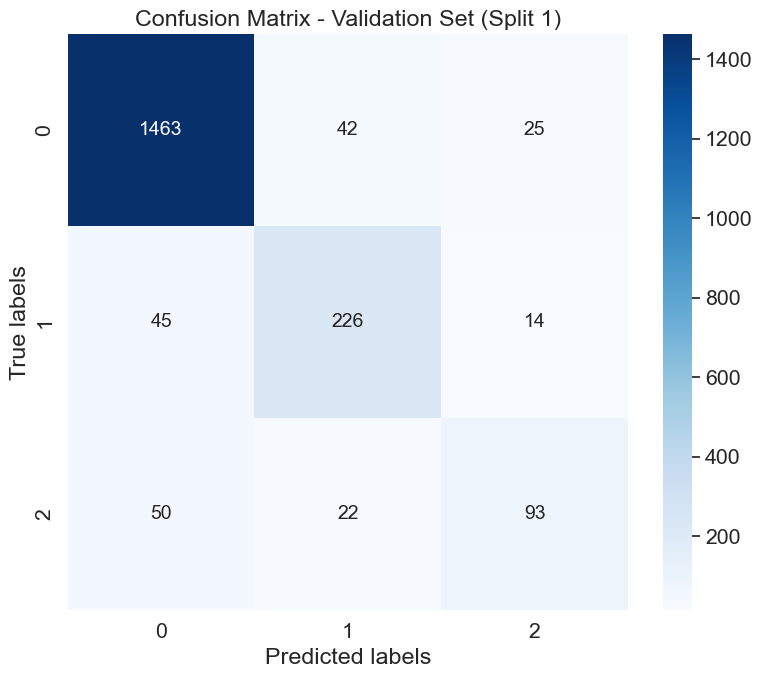

Split 2/5
  Train sequences: 5955 | Val sequences: 1980
Training 500 epochs...
Epoch   1/500 | Train: Loss=28.1660, F1 Score=0.4626 | Val: Loss=1.3777, F1 Score=0.7268 | LR=7.00e-04
Epoch  20/500 | Train: Loss=5.7085, F1 Score=0.9030 | Val: Loss=1.6387, F1 Score=0.4273 | LR=7.00e-04
Epoch  40/500 | Train: Loss=3.9785, F1 Score=0.9509 | Val: Loss=0.7196, F1 Score=0.8362 | LR=7.00e-04
Epoch  60/500 | Train: Loss=2.8886, F1 Score=0.9621 | Val: Loss=0.7731, F1 Score=0.8286 | LR=7.00e-04
Epoch  80/500 | Train: Loss=2.1520, F1 Score=0.9671 | Val: Loss=0.7304, F1 Score=0.8375 | LR=7.00e-04
Epoch 100/500 | Train: Loss=1.6720, F1 Score=0.9684 | Val: Loss=0.7763, F1 Score=0.9130 | LR=7.00e-04
Epoch 120/500 | Train: Loss=1.3354, F1 Score=0.9695 | Val: Loss=0.8223, F1 Score=0.8918 | LR=7.00e-04
Epoch 140/500 | Train: Loss=1.1130, F1 Score=0.9751 | Val: Loss=0.7626, F1 Score=0.9105 | LR=7.00e-04
Epoch 160/500 | Train: Loss=0.9623, F1 Score=0.9719 | Val: Loss=0.8197, F1 Score=0.9142 | LR=7.00e-04
Ep

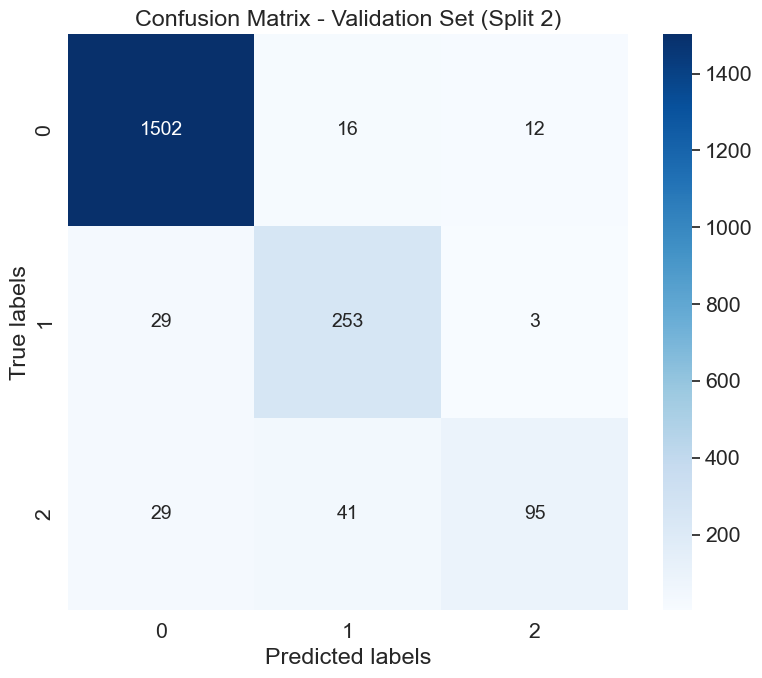

Split 3/5
  Train sequences: 5955 | Val sequences: 1980
Training 500 epochs...
Epoch   1/500 | Train: Loss=28.1477, F1 Score=0.4753 | Val: Loss=1.1751, F1 Score=0.5732 | LR=7.00e-04
Epoch  20/500 | Train: Loss=5.7073, F1 Score=0.9307 | Val: Loss=0.9445, F1 Score=0.6800 | LR=7.00e-04
Epoch  40/500 | Train: Loss=3.9475, F1 Score=0.9356 | Val: Loss=0.7740, F1 Score=0.8876 | LR=7.00e-04
Epoch  60/500 | Train: Loss=2.9200, F1 Score=0.9670 | Val: Loss=0.8121, F1 Score=0.9046 | LR=7.00e-04
Epoch  80/500 | Train: Loss=2.1919, F1 Score=0.9687 | Val: Loss=0.8860, F1 Score=0.8970 | LR=7.00e-04
Epoch 100/500 | Train: Loss=1.6972, F1 Score=0.9612 | Val: Loss=0.7782, F1 Score=0.9093 | LR=7.00e-04
Epoch 120/500 | Train: Loss=1.3893, F1 Score=0.9644 | Val: Loss=0.8404, F1 Score=0.8849 | LR=7.00e-04
Early stopping triggered after 124 epochs.
Best model restored from epoch 74 with val_f1 0.9228


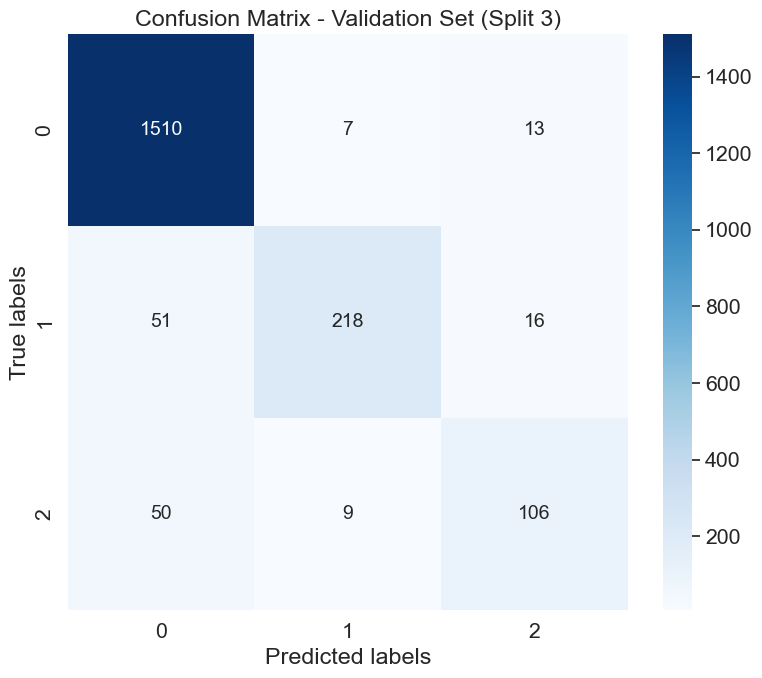

Split 4/5
  Train sequences: 5955 | Val sequences: 1980
Training 500 epochs...
Epoch   1/500 | Train: Loss=28.1983, F1 Score=0.4430 | Val: Loss=1.5835, F1 Score=0.7172 | LR=7.00e-04
Epoch  20/500 | Train: Loss=5.7527, F1 Score=0.8914 | Val: Loss=0.9836, F1 Score=0.8804 | LR=7.00e-04
Epoch  40/500 | Train: Loss=4.0661, F1 Score=0.9182 | Val: Loss=1.1519, F1 Score=0.8325 | LR=7.00e-04
Epoch  60/500 | Train: Loss=2.9426, F1 Score=0.9685 | Val: Loss=0.8514, F1 Score=0.9071 | LR=7.00e-04
Epoch  80/500 | Train: Loss=2.2447, F1 Score=0.9731 | Val: Loss=0.9178, F1 Score=0.8421 | LR=7.00e-04
Epoch 100/500 | Train: Loss=1.7872, F1 Score=0.9790 | Val: Loss=0.8050, F1 Score=0.8915 | LR=7.00e-04
Early stopping triggered after 109 epochs.
Best model restored from epoch 59 with val_f1 0.9191


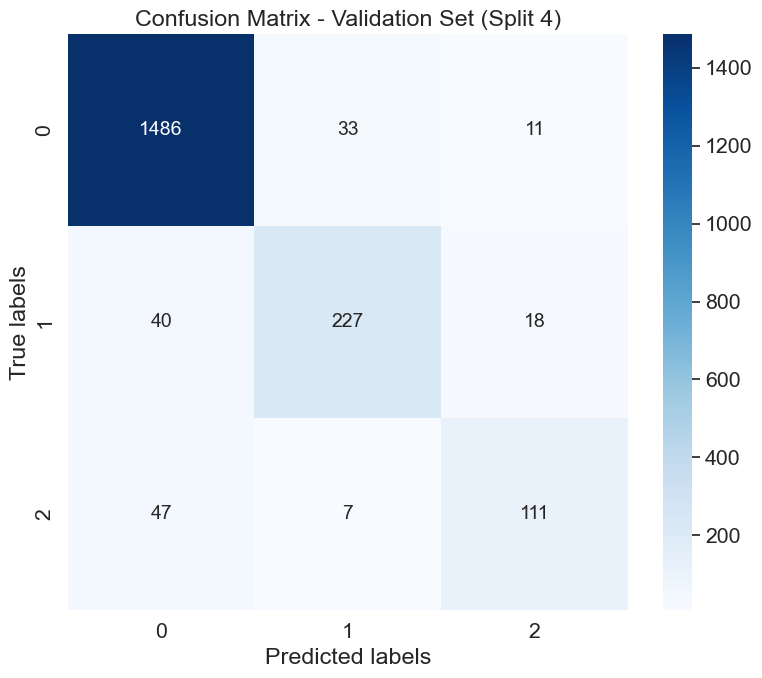

Split 5/5
  Train sequences: 5955 | Val sequences: 1980
Training 500 epochs...
Epoch   1/500 | Train: Loss=28.1054, F1 Score=0.4086 | Val: Loss=1.4139, F1 Score=0.5969 | LR=7.00e-04
Epoch  20/500 | Train: Loss=5.7940, F1 Score=0.8949 | Val: Loss=0.9224, F1 Score=0.8060 | LR=7.00e-04
Epoch  40/500 | Train: Loss=4.0236, F1 Score=0.9518 | Val: Loss=1.0577, F1 Score=0.6735 | LR=7.00e-04
Epoch  60/500 | Train: Loss=2.9452, F1 Score=0.9677 | Val: Loss=0.8313, F1 Score=0.8977 | LR=7.00e-04
Epoch  80/500 | Train: Loss=2.1754, F1 Score=0.9705 | Val: Loss=0.7297, F1 Score=0.9035 | LR=7.00e-04
Epoch 100/500 | Train: Loss=1.6437, F1 Score=0.9716 | Val: Loss=0.8659, F1 Score=0.8897 | LR=7.00e-04
Epoch 120/500 | Train: Loss=1.3146, F1 Score=0.9785 | Val: Loss=0.7416, F1 Score=0.9065 | LR=7.00e-04
Epoch 140/500 | Train: Loss=1.0834, F1 Score=0.9817 | Val: Loss=0.7642, F1 Score=0.9065 | LR=7.00e-04
Epoch 160/500 | Train: Loss=0.9521, F1 Score=0.9795 | Val: Loss=0.8524, F1 Score=0.8946 | LR=7.00e-04


In [ ]:
%%time

# Execute search
results, best_config, best_score = grid_search_cv_rnn(
    df=df_dataset_reduced,
    param_grid=param_grid,
    fixed_params=fixed_params,
    cv_params=cv_params,
    plot_confusion_matrix=True  #Cambia qui se vuoi vedere le confusion matrix durante la grid search
)

In [ ]:
# Save and print
save_grid_search_results(results, best_config, best_score)

In [ ]:
# Visualise results
plot_top_configurations_rnn(results, k_splits=K, top_n=5)

In [ ]:
# --- 1. Combine fixed and best hyperparameters ---
# 'fixed_params' and 'best_config' are loaded from the grid search cell
final_best_params = {**fixed_params, **best_config}

# Generate config string (from grid params only) to find saved model files
# If best_config is empty (no params tuned), use EXPERIMENT_NAME directly as the key
if not best_config:
    best_config_str = EXPERIMENT_NAME
else:
    best_config_str = EXPERIMENT_NAME + "_".join([f"{k}_{v}" for k, v in best_config.items()]).replace('.', 'p')

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

features_to_normalize = list(set(CONTINUOUS_COLS_REDUCED) - set(COLS_TO_EXCLUDE_FROM_NORMALIZATION))

# Initialise lists for metrics
test_accuracies = []
test_precisions = []
test_recall_scores = []
test_f1_scores = []
all_test_targets = []  # For aggregated confusion matrix
all_test_preds = []  # For aggregated confusion matrix

# --- 2. Begin evaluation loop across the K splits ---
for split in range(K):
    print(f"Evaluating Split {split + 1}/{K} using best config: {best_config_str}")

    unique_samples = df_dataset_reduced['sample_index'].unique()

    # --- 3. Regenera la esatta suddivisione dei dati per questo fold ---
    # Questa logica deve essere identica a k_shuffle_split_cross_validation_round_rnn
    # Stratified split su sample_index per mantenere la distribuzione delle label
    labels_map = labels_df.set_index('sample_index')['label']
    y_all = np.array([labels_map[sid] for sid in unique_samples], dtype=np.int64)

    # Primo split: train vs (val+test)
    train_ids, temp_ids, y_train, y_temp = train_test_split(
        unique_samples,
        y_all,
        test_size=N_VAL_SAMPLE_INDEXES + N_TEST_SAMPLE_INDEXES,
        stratify=y_all,
        random_state=SEED + split,
        shuffle=True
    )

    # Secondo split: val vs test
    val_ids, test_ids, y_val, y_test = train_test_split(
        temp_ids,
        y_temp,
        test_size=N_TEST_SAMPLE_INDEXES,
        stratify=y_temp,
        random_state=SEED + split,
        shuffle=True
    )

    df_train = df_dataset_reduced[df_dataset_reduced['sample_index'].isin(train_ids)].copy()
    df_test = df_dataset_reduced[df_dataset_reduced['sample_index'].isin(test_ids)].copy()

    # Normalise features (fit on THIS split's training data)
    mm_scaler = StandardScaler()  #MinMaxScaler()
    df_train[features_to_normalize] = mm_scaler.fit_transform(df_train[features_to_normalize])
    df_test[features_to_normalize] = mm_scaler.transform(df_test[features_to_normalize])

    labels_df_split = labels_df[labels_df['sample_index'].isin(test_ids)].copy()

    # --- 5. Build test sequences ---
    # Use the best window/stride from final_best_params
    X_test_cont, X_test_cat, y_test = build_sequences(
        df_test,
        labels_df_split,
        continuous_cols=CONTINUOUS_COLS_REDUCED,
        categorical_cols=CATEGORICAL_COLS_REDUCED,
        window=final_best_params['window_size'],
        stride=final_best_params['stride'],
        padding_strategy=final_best_params.get('padding_strategy', 'adaptive'),
        lookback_steps=final_best_params.get('padding_lookback_steps', 10)
    )

    # --- 6. Create the Test DataLoader ---
    test_ds = TensorDataset(torch.from_numpy(X_test_cont).float(), torch.from_numpy(X_test_cat).long(),
                            torch.from_numpy(y_test).long())
    test_loader = make_loader(
        test_ds,
        batch_size=final_best_params['batch_size'],
        shuffle=False,
        drop_last=False
    )

    # Handle empty test sets from user splits
    if len(test_ds) == 0:
        print(f"  WARNING: Test set for split {split + 1} is empty. Skipping.")
        continue

    # --- 7. Initialise the Model ---
    # Use the best architecture parameters from the grid search
    model = RecurrentClassifier(
        continuous_input_size=len(CONTINUOUS_COLS_REDUCED),
        categorical_cardinalities=categorical_cardinalities,
        embedding_dims=embedding_dims,
        hidden_size=final_best_params['hidden_size'],
        num_layers=final_best_params['hidden_layers'],
        num_classes=num_classes,
        dropout_rate=final_best_params['dropout_rate'],
        rnn_inside_dropout=final_best_params.get('rnn_inside_dropout', 0.0),
        bidirectional=final_best_params['bidirectional'],
        rnn_type=final_best_params['rnn_type'],
        use_conv=final_best_params.get('use_conv', False),
        conv_num_filters=final_best_params.get('conv_num_filters', 64),
        conv_kernel_size=final_best_params.get('conv_kernel_size', 5),
        conv_num_layers=final_best_params.get('conv_num_layers', 1),
        conv_stride=final_best_params.get('conv_stride', 1),
        conv_pool=final_best_params.get('conv_pool', None),
        conv_batch_norm=final_best_params.get('conv_batch_norm', True),
        use_attention=final_best_params.get('use_attention', False),
    ).to(device)

    # --- 8. Load the model weights for this specific split and config ---
    # Fix: Use best_config_str directly as it already holds the experiment name or combined name.
    model_path = f"models/{best_config_str}/split_{split}_model.pt"

    try:
        model.load_state_dict(torch.load(model_path, map_location=device))
    except FileNotFoundError:
        print(f"  ERROR: Model file not found at {model_path}")
        print(f"  Skipping split {split + 1}.")
        continue

    model.eval()  # Set model to evaluation mode

    # --- 9. Esecuzione inferenza sul test set (continue + categoriche) ---
    split_test_preds, split_test_targets = [], []
    with torch.no_grad():
        for x_cont, x_cat, y in test_loader:
            x_cont = x_cont.to(device)
            x_cat = x_cat.to(device)
            y = y.to(device)
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(x_cont, x_cat)
            preds = logits.argmax(dim=1).cpu().numpy()
            split_test_preds.append(preds)
            split_test_targets.append(y.cpu().numpy())

    split_test_preds = np.concatenate(split_test_preds)
    split_test_targets = np.concatenate(split_test_targets)

    # --- 10. Calculate and store metrics for this split ---
    split_test_acc = accuracy_score(split_test_targets, split_test_preds)
    split_test_prec = precision_score(split_test_targets, split_test_preds, average='weighted', zero_division=0)
    split_test_rec = recall_score(split_test_targets, split_test_preds, average='weighted', zero_division=0)
    split_test_f1 = f1_score(split_test_targets, split_test_preds, average='weighted', zero_division=0)

    print(f"F1 Score on test set for Split {split + 1}: {split_test_f1:.4f}")

    test_accuracies.append(split_test_acc)
    test_precisions.append(split_test_prec)
    test_recall_scores.append(split_test_rec)
    test_f1_scores.append(split_test_f1)

    all_test_targets.extend(split_test_targets)
    all_test_preds.extend(split_test_preds)

# --- 11. After the loop: Print mean metrics and plot confusion matrix ---
print("\nAverage metrics across all splits on the test set:")
print(f"Mean Accuracy: {np.mean(test_accuracies):.4f} \u00b1 {np.std(test_accuracies):.4f}")
print(f"Mean Precision: {np.mean(test_precisions):.4f} \u00b1 {np.std(test_precisions):.4f}")
print(f"Mean Recall: {np.mean(test_recall_scores):.4f} \u00b1 {np.std(test_recall_scores):.4f}")
print(f"Mean F1 score: {np.mean(test_f1_scores):.4f} \u00b1 {np.std(test_f1_scores):.4f}")

# Generate confusion matrix for the concatenated test sets
cm = confusion_matrix(all_test_targets, all_test_preds)
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Visualise confusion matrix
plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=labels, fmt='',
            cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Aggregated Confusion Matrix — Test Sets Across Splits')
plt.tight_layout()
plt.show()

## **Inference on kaggle dataset**

In [ ]:
# --- 1. Combine fixed and best hyperparameters ---
# 'fixed_params' and 'best_config' are loaded from the grid search cell
final_best_params = {**fixed_params, **best_config}

# Generate config string (from grid params only) to find saved model files
# If best_config is empty (no params tuned), use EXPERIMENT_NAME directly as the key
if not best_config:
    best_config_str = EXPERIMENT_NAME
else:
    best_config_str = EXPERIMENT_NAME + "_".join([f"{k}_{v}" for k, v in best_config.items()]).replace('.', 'p')

# 1) Ricava la config migliore e lo split migliore
split_scores = [results[best_config_str].get(f"split_{i}", -1.0) for i in range(K)]
best_split_idx = int(np.argmax(split_scores))

print(f"Miglior configurazione: {best_config_str}")
print(f"Miglior split: {best_split_idx} con F1={split_scores[best_split_idx]:.4f}")

# 2) Istanzia il modello con gli iperparametri migliori
best_model = RecurrentClassifier(
    continuous_input_size=len(CONTINUOUS_COLS_REDUCED),
    categorical_cardinalities=categorical_cardinalities,
    embedding_dims=embedding_dims,
    hidden_size=final_best_params['hidden_size'],
    num_layers=final_best_params['hidden_layers'],
    num_classes=num_classes,
    dropout_rate=final_best_params['dropout_rate'],
    rnn_type=final_best_params['rnn_type'],
    bidirectional=final_best_params['bidirectional'],
    rnn_inside_dropout=final_best_params.get('rnn_inside_dropout', 0.0),
    use_conv=final_best_params.get('use_conv', False),
    conv_num_filters=final_best_params.get('conv_num_filters', 64),
    conv_kernel_size=final_best_params.get('conv_kernel_size', 5),
    conv_num_layers=final_best_params.get('conv_num_layers', 1),
    conv_stride=final_best_params.get('conv_stride', 1),
    conv_pool=final_best_params.get('conv_pool', None),
    conv_batch_norm=final_best_params.get('conv_batch_norm', True),
    use_attention=final_best_params.get('use_attention', False),
).to(device)

# 3) Carica i pesi del modello migliore e lo scaler associato
best_model_path = f"models/{best_config_str}/split_{best_split_idx}_model.pt"
best_model.load_state_dict(torch.load(best_model_path, map_location=device))
best_model.eval()

best_scaler_path = f"models/{best_config_str}/split_{best_split_idx}_scaler.pkl"
scaler = joblib.load(best_scaler_path)

print(f"Modello caricato da {best_model_path}")
print(f"Scaler caricato da {best_scaler_path}")

In [ ]:
submission_path = f"submissions/{EXPERIMENT_NAME}_submission.csv"

In [ ]:
# 4) Funzione per creare le sequenze per l'inferenza (senza etichette)
def build_sequences_inference(df, continuous_cols, categorical_cols, window=200, stride=200,
                              padding_strategy='adaptive', lookback_steps=10):
    """
    Build sequences for inference with adaptive padding (no labels).

    Args:
        df: DataFrame with time series data
        continuous_cols: List of continuous feature columns
        categorical_cols: List of categorical feature columns
        window: Window size for sequences
        stride: Stride for sliding window
        padding_strategy: 'adaptive' (mean/mode), 'repeat' (repeat last), or 'zero' (zeros)
        lookback_steps: Number of timesteps for computing padding statistics

    Returns:
        X_continuous, X_categorical, sample_owners (array of sample_index for each window)
    """

    X_cont, X_cat, owners = [], [], []

    # Pre-compute global statistics for fallback (only if adaptive)
    if padding_strategy == 'adaptive':
        global_cont_mean = df[continuous_cols].mean().values.astype('float32')
        global_cat_mode = df[categorical_cols].mode().iloc[0].values.astype('int8')

    for sid, g in df.groupby('sample_index'):
        cont = g[continuous_cols].values.astype('float32')
        cat = g[categorical_cols].values.astype('int64')

        pad = (window - (len(cont) % window)) % window

        if pad > 0:
            if padding_strategy == 'adaptive':
                # Use statistics from last timesteps
                lookback = min(lookback_steps, len(cont))

                if lookback > 0:
                    pad_cont_value = np.mean(cont[-lookback:], axis=0, keepdims=True)
                    pad_cat_value = np.array([
                        np.bincount(cat[-lookback:, i]).argmax()
                        for i in range(cat.shape[1])
                    ]).reshape(1, -1)
                else:
                    pad_cont_value = global_cont_mean.reshape(1, -1)
                    pad_cat_value = global_cat_mode.reshape(1, -1)

                padding_cont = np.repeat(pad_cont_value, pad, axis=0).astype('float32')
                padding_cat = np.repeat(pad_cat_value, pad, axis=0).astype('int64')

            elif padding_strategy == 'repeat':
                if len(cont) > 0:
                    padding_cont = np.repeat(cont[-1:], pad, axis=0)
                    padding_cat = np.repeat(cat[-1:], pad, axis=0)
                else:
                    padding_cont = np.zeros((pad, cont.shape[1]), dtype='float32')
                    padding_cat = np.zeros((pad, cat.shape[1]), dtype='int64')
            else:  # 'zero' or default
                padding_cont = np.zeros((pad, cont.shape[1]), dtype='float32')
                padding_cat = np.zeros((pad, cat.shape[1]), dtype='int64')

            cont = np.concatenate([cont, padding_cont], axis=0)
            cat = np.concatenate([cat, padding_cat], axis=0)

        # Build windows
        i = 0
        while i + window <= len(cont):
            X_cont.append(cont[i:i + window])
            X_cat.append(cat[i:i + window])
            owners.append(sid)
            i += stride

    return (np.asarray(X_cont, dtype=np.float32),
            np.asarray(X_cat, dtype=np.int64),
            np.asarray(owners, dtype=np.int32))

In [ ]:
# 5) Normalizza il kaggle test con lo scaler CORRETTO (caricato sopra), quello relativo allo split migliore
kaggle_test_df_reduced[features_to_normalize] = scaler.transform(kaggle_test_df_reduced[features_to_normalize])

In [ ]:
from collections import Counter

# 6) Costruisci le sequenze per Kaggle test
Xk_cont, Xk_cat, owners = build_sequences_inference(
    kaggle_test_df_reduced,
    continuous_cols=CONTINUOUS_COLS_REDUCED,
    categorical_cols=CATEGORICAL_COLS_REDUCED,
    window=final_best_params['window_size'],
    stride=final_best_params['stride'],
    padding_strategy=final_best_params.get('padding_strategy', 'adaptive'),
    lookback_steps=final_best_params.get('padding_lookback_steps', 10)
)

# 7) Inference sui windows
kaggle_ds = TensorDataset(
    torch.from_numpy(Xk_cont).float(),
    torch.from_numpy(Xk_cat).long()
)
kaggle_loader = make_loader(kaggle_ds, batch_size=final_best_params['batch_size'], shuffle=False, drop_last=False)

all_preds = []
with torch.no_grad():
    for xb_cont, xb_cat in kaggle_loader:
        xb_cont = xb_cont.to(device)
        xb_cat = xb_cat.to(device)
        logits = best_model(xb_cont, xb_cat)
        preds = logits.argmax(dim=1).detach().cpu().numpy()
        all_preds.append(preds)

all_preds = np.concatenate(all_preds) if len(all_preds) else np.array([], dtype=np.int64)

# 8) Aggrega per sample_index (maggioranza)
preds_per_sample = {}
for sid, p in zip(owners, all_preds):
    preds_per_sample.setdefault(int(sid), []).append(int(p))

final_idx = {sid: Counter(v).most_common(1)[0][0] for sid, v in preds_per_sample.items()}

# 9) Mappa a etichette testuali e crea submission
inv_label_map = {0: 'no_pain', 1: 'low_pain', 2: 'high_pain'}
submission = pd.DataFrame({
    'sample_index': list(final_idx.keys()),
    'label': [inv_label_map[int(v)] for v in final_idx.values()]
}).sort_values('sample_index', kind='stable')

os.makedirs("submissions", exist_ok=True)
submission.to_csv(submission_path, index=False)

print(f"Submission salvata in {submission_path}")

